In [ ]:
import csv
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd

from dataclasses import dataclass
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df1 = pd.read_csv('/content/Data Price Prediction - All Data - Bandeng-Eceran ini.csv', sep =',')

In [ ]:
Q1 = df1['Harga'].quantile(0.25)
Q3 = df1['Harga'].quantile(0.75)
IQR = Q3 - Q1
# df = df1[(df1['Harga'] >= Q1 - 1.5 * IQR) & (df1['Harga'] <= Q3 + 1.5 * IQR)]
threshold = 1.5*IQR
median = np.median(df1['Harga'])
outliers = (df1['Harga'] < Q1 - threshold) | (df1['Harga'] > Q3 + threshold)
df1[outliers] = median

In [ ]:
def get_data(data):
    
    times = []
    value = []

    i = 0
    for row in data:
      times.append(i)
      value.append(float(row)/1000)
      i+=1

    
    return times, value


In [ ]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [ ]:
# Test your function and save all "global" variables within the G class (G stands for global)
@dataclass
class G:
    # FILE_CSV = '/content/drive/MyDrive/ML/Data Price Prediction - Yang perlu aja - Bandeng-Grosir.csv'
    times, price = get_data(df1['Harga'])
    TIME = np.array(times)
    SERIES = np.array(price)
    SPLIT_TIME = 72
    WINDOW_SIZE = 12
    BATCH_SIZE = 6
    SHUFFLE_BUFFER_SIZE = 10


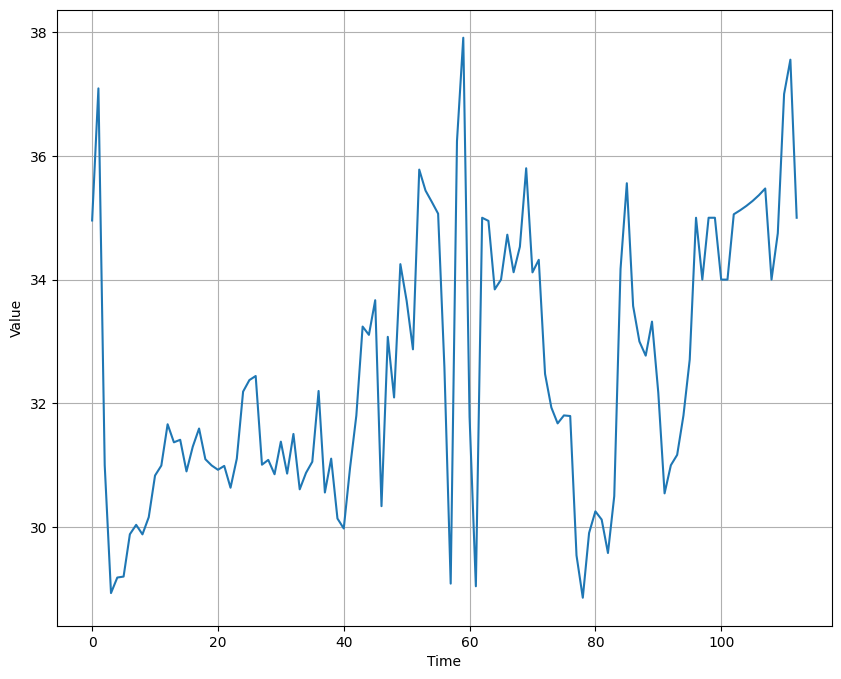

In [ ]:
plt.figure(figsize=(10, 8))
plot_series(G.TIME, G.SERIES)
plt.show()

In [ ]:
def train_val_split(time, series, time_step=G.SPLIT_TIME):

    time_train = time[:time_step]
    series_train = series[:time_step]
    time_valid = time[time_step:]
    series_valid = series[time_step:]

    return time_train, series_train, time_valid, series_valid

In [ ]:
# Split the dataset
time_train, series_train, time_valid, series_valid = train_val_split(G.TIME, G.SERIES)

In [ ]:
def windowed_dataset(series, window_size=G.WINDOW_SIZE, batch_size=G.BATCH_SIZE, shuffle_buffer=G.SHUFFLE_BUFFER_SIZE):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[-1]))
    ds = ds.batch(batch_size).prefetch(1)
    return ds


In [ ]:
# Apply the transformation to the training set
train_set = windowed_dataset(series_train, window_size=G.WINDOW_SIZE, batch_size=G.BATCH_SIZE, shuffle_buffer=G.SHUFFLE_BUFFER_SIZE)

## Build the Model


In [ ]:
def create_model():
    
    model = tf.keras.models.Sequential([ 
        tf.keras.layers.Conv1D(filters=32, kernel_size=3,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[G.WINDOW_SIZE, 1]),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
        tf.keras.layers.Dense(30, activation='relu'),
        tf.keras.layers.Dense(1),
        tf.keras.layers.Lambda(lambda x: x * 100)
    ]) 

    return model
model = create_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 12, 32)            128       
                                                                 
 bidirectional (Bidirectiona  (None, 12, 64)           16640     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 12, 64)           24832     
 nal)                                                            
                                                                 
 bidirectional_2 (Bidirectio  (None, 64)               24832     
 nal)                                                            
                                                                 
 dense (Dense)               (None, 30)                1950      
                                                        

In [ ]:
# Test your uncompiled model
uncompiled_model = create_model()

try:
    uncompiled_model.predict(train_set)
except:
    print("Your current architecture is incompatible with the windowed dataset, try adjusting it.")
else:
    print("Your current architecture is compatible with the windowed dataset! :)")

10/10 [==============================] - 2s 29ms/step
Your current architecture is compatible with the windowed dataset! :)


In [ ]:
# Get initial weights
init_weights = model.get_weights()

# Set the learning rate scheduler
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))

# Initialize the optimizer
optimizer = tf.keras.optimizers.SGD(momentum=0.9)

# Set the training parameters
model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer)

# Train the model
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
10/10 [==============================] - 8s 33ms/step - loss: 56.6568 - lr: 1.0000e-08
Epoch 2/100
10/10 [==============================] - 0s 17ms/step - loss: 56.4995 - lr: 1.1220e-08
Epoch 3/100
10/10 [==============================] - 0s 18ms/step - loss: 56.2776 - lr: 1.2589e-08
Epoch 4/100
10/10 [==============================] - 0s 16ms/step - loss: 56.0139 - lr: 1.4125e-08
Epoch 5/100
10/10 [==============================] - 0s 17ms/step - loss: 55.7108 - lr: 1.5849e-08
Epoch 6/100
10/10 [==============================] - 0s 16ms/step - loss: 55.3662 - lr: 1.7783e-08
Epoch 7/100
10/10 [==============================] - 0s 17ms/step - loss: 54.9769 - lr: 1.9953e-08
Epoch 8/100
10/10 [==============================] - 0s 18ms/step - loss: 54.5381 - lr: 2.2387e-08
Epoch 9/100
10/10 [==============================] - 0s 18ms/step - loss: 54.0441 - lr: 2.5119e-08
Epoch 10/100
10/10 [==============================] - 0s 17ms/step - loss: 53.4884 - lr: 2.8184e-08
Epoch 11/

(1e-08, 0.001, 0.0, 50.0)

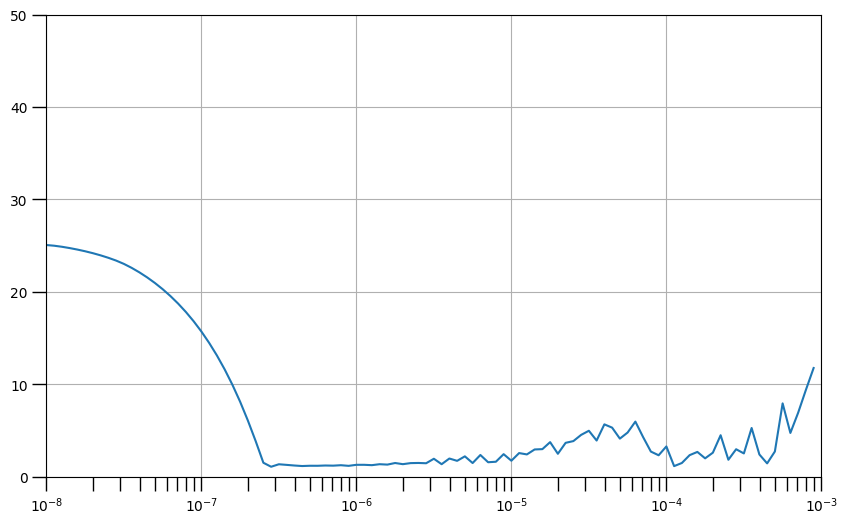

In [ ]:
# Define the learning rate array
lrs = 1e-8 * (10 ** (np.arange(100) / 20))

# Set the figure size
plt.figure(figsize=(10, 6))

# Set the grid
plt.grid(True)

# Plot the loss in log scale
plt.semilogx(lrs, history.history["loss"])

# Increase the tickmarks size
plt.tick_params('both', length=10, width=1, which='both')

# Set the plot boundaries
plt.axis([1e-8, 1e-3, 0, 50])

In [ ]:
# Reset states generated by Keras
tf.keras.backend.clear_session()

# Reset the weights
model.set_weights(init_weights)

In [ ]:
# Set the learning rate
learning_rate = 1e-6

# Set the optimizer
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)

# Set the training parameters
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

In [ ]:
# Train the model
Epochs = 80
history = model.fit(train_set,epochs=Epochs)

Epoch 1/80
10/10 [==============================] - 8s 19ms/step - loss: 53.5535 - mae: 54.0535
Epoch 2/80
10/10 [==============================] - 0s 16ms/step - loss: 40.9648 - mae: 41.4648
Epoch 3/80
10/10 [==============================] - 0s 16ms/step - loss: 26.5612 - mae: 27.0612
Epoch 4/80
10/10 [==============================] - 0s 16ms/step - loss: 12.0362 - mae: 12.5362
Epoch 5/80
10/10 [==============================] - 0s 17ms/step - loss: 1.8357 - mae: 2.2936
Epoch 6/80
10/10 [==============================] - 0s 16ms/step - loss: 2.7154 - mae: 3.1783
Epoch 7/80
10/10 [==============================] - 0s 16ms/step - loss: 1.0506 - mae: 1.4295
Epoch 8/80
10/10 [==============================] - 0s 18ms/step - loss: 1.5305 - mae: 1.9974
Epoch 9/80
10/10 [==============================] - 0s 16ms/step - loss: 1.4000 - mae: 1.8583
Epoch 10/80
10/10 [==============================] - 0s 16ms/step - loss: 1.1449 - mae: 1.5820
Epoch 11/80
10/10 [==============================] 

In [ ]:
def model_forecast(model, series, window_size, batch_size):

    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)

    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size, shift=1, drop_remainder=True)

    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda w: w.batch(window_size))
    
    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)
    
    # Get predictions on the entire dataset
    forecast = model.predict(dataset)
    
    return forecast

In [ ]:
def compute_metrics(true_series, forecast):
    
    mse = tf.keras.metrics.mean_squared_error(true_series, forecast).numpy()
    mae = tf.keras.metrics.mean_absolute_error(true_series, forecast).numpy()

    return mse, mae

In [ ]:
cnn_forecast = model_forecast(model, G.SERIES, G.WINDOW_SIZE, G.BATCH_SIZE).squeeze()
cnn_forecast = cnn_forecast[G.SPLIT_TIME - G.WINDOW_SIZE:-1]
mse, mae = compute_metrics(series_valid, cnn_forecast)

print(f"mse: {mse:.2f}, mae: {mae:.2f} for forecast")

17/17 [==============================] - 3s 5ms/step
mse: 4.68, mae: 1.93 for forecast


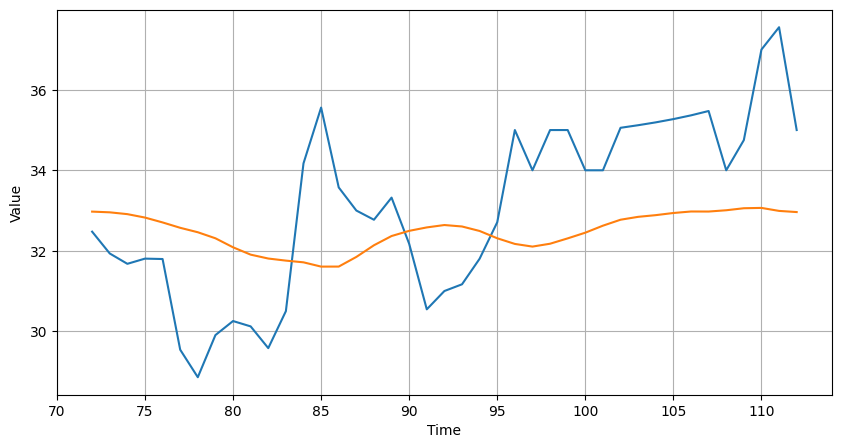

In [ ]:
# Plot the forecast
plt.figure(figsize=(10, 5))
plot_series(time_valid, series_valid)
plot_series(time_valid, cnn_forecast)

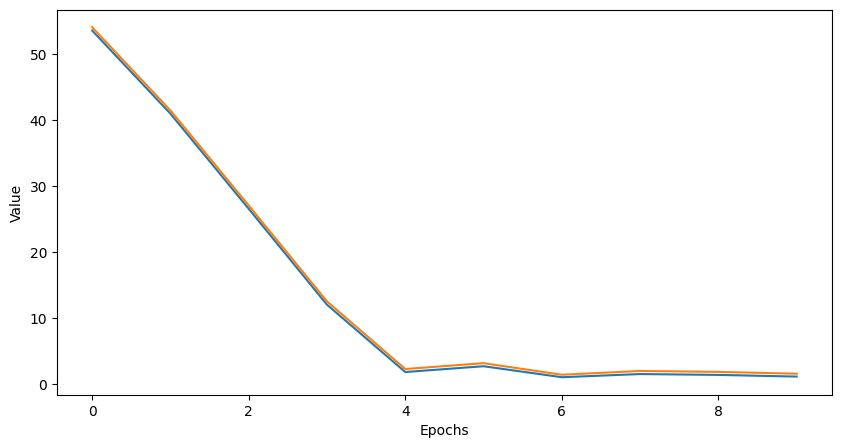

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(range(10), history.history["loss"][:10])
plt.plot(range(10), history.history["mae"][:10])
plt.xlabel("Epochs")
plt.ylabel("Value")

plt.show()

In [ ]:
# prepare data for forecasting
last_window = G.SERIES[-G.WINDOW_SIZE:]
last_window = np.reshape(last_window, (1, G.WINDOW_SIZE, 1))

# make a forecast for 5 steps ahead
forecast_norm = []
for _ in range(24):
    pred = model.predict(last_window)[0, 0]
    forecast_norm.append(pred)
    last_window = np.roll(last_window, -1, axis=1)
    last_window[0, -1, 0] = pred

# invert the normalization
forecast = forecast_norm
print("Forecast:", forecast)

1/1 [==============================] - 0s 18ms/step
Forecast: [33.060413, 33.157547, 33.160755, 33.077663, 32.985313, 32.901306, 32.810154, 32.71289, 32.58897, 32.510353, 32.490173, 32.48883, 32.47298, 32.452126, 32.43549, 32.42233, 32.411907, 32.40397, 32.398254, 32.394062, 32.39074, 32.38782, 32.385284, 32.383232]


In [ ]:
model.save('Bandengn(Grosir).h5')